<a href="https://colab.research.google.com/github/AswathyS9778/DSML/blob/main/train_dataset_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [81]:
DATASET_PATH = 'data/voice6'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'voice6.zip',
      origin="/data/voice6.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [82]:
words = np.array(tf.io.gfile.listdir(str(data_dir)))
words = words[words != 'README.md']
print('words:', words)

words: ['howareyou' 'college' 'banana' 'apple' 'hobbies' 'hello' 'areyoufine']


In [83]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/words[0]))))
print('Example file tensor:', filenames[1])

Number of total examples: 7
Number of examples per label: 1
Example file tensor: tf.Tensor(b'data/voice6/hello/d.wav', shape=(), dtype=string)


In [84]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 7
Validation set size 0
Test set size 7


In [85]:
test_file = tf.io.read_file(DATASET_PATH+'/college/college.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([94936, 1])

In [86]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [87]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  
  return parts[-2]

In [88]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [89]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

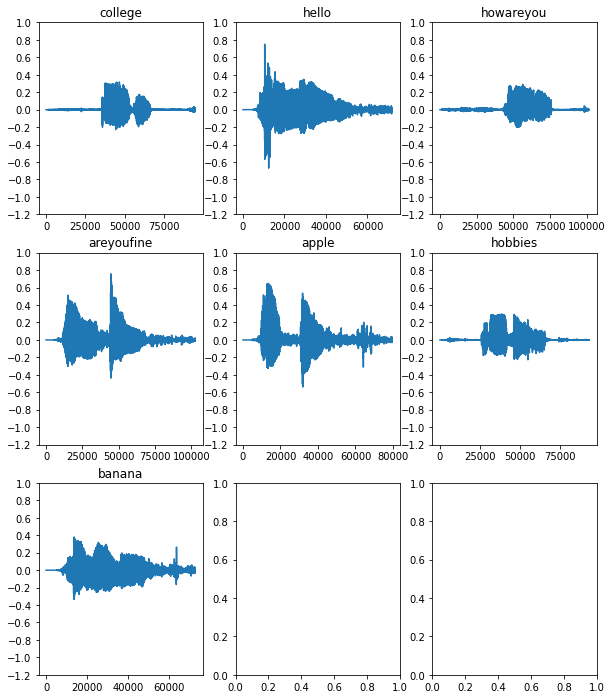

In [90]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [91]:
def get_spectrogram(waveform):
  
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [92]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

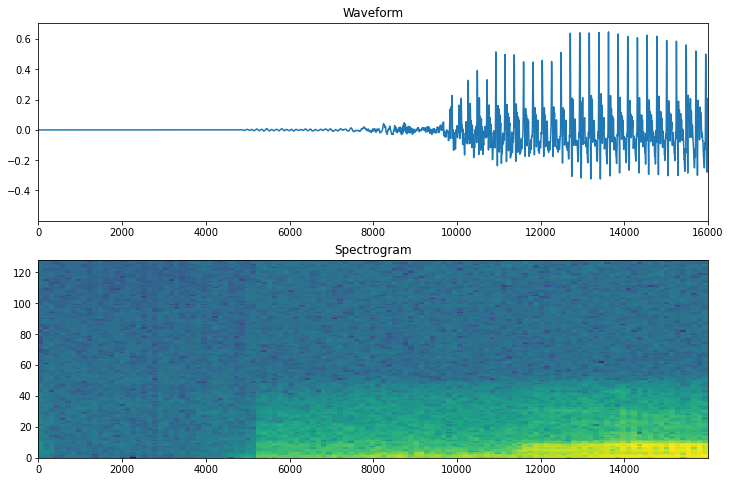

In [72]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [93]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == words)
  return spectrogram, label_id

In [94]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

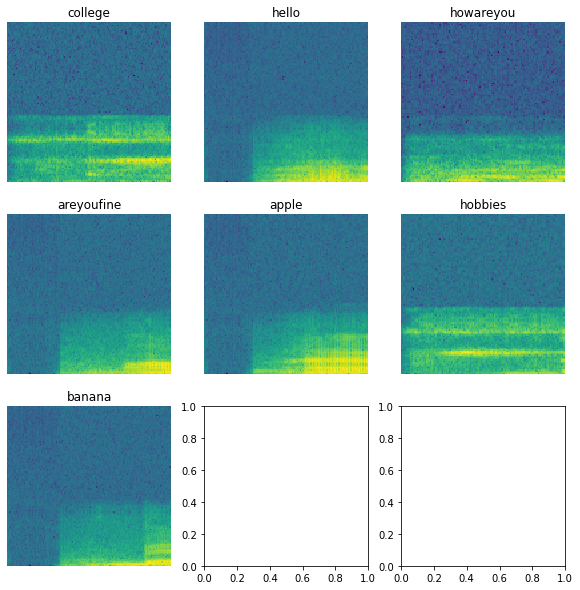

In [96]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(words[label_id.numpy()])
  ax.axis('off')

plt.show()

In [97]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [98]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)



In [99]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [100]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [101]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  print('Label:', label)

Label: college


In [102]:
print('Audio playback')
display.display(display.Audio(waveform, rate=42000))

Audio playback


In [103]:
for waveform, label in waveform_ds.take(2):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)

Label: hello


In [104]:
print('Audio playback')
display.display(display.Audio(waveform, rate=42000))

Audio playback


In [105]:
for waveform, label in waveform_ds.take(3):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)

Label: howareyou


In [106]:
print('Audio playback')
display.display(display.Audio(waveform, rate=42000))

Audio playback


In [107]:
for waveform, label in waveform_ds.take(4):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)

Label: areyoufine


In [108]:
print('Audio playback')
display.display(display.Audio(waveform, rate=42000))

Audio playback


In [109]:
for waveform, label in waveform_ds.take(5):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)

Label: apple


In [110]:
print('Audio playback')
display.display(display.Audio(waveform, rate=42000))

Audio playback


In [111]:
for waveform, label in waveform_ds.take(6):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)

Label: hobbies


In [112]:
print('Audio playback')
display.display(display.Audio(waveform, rate=42000))

Audio playback


In [113]:
for waveform, label in waveform_ds.take(7):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)

Label: banana


In [114]:
print('Audio playback')
display.display(display.Audio(waveform, rate=42000))

Audio playback


In [115]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(words)

norm_layer = layers.Normalization()

norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)       

In [117]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [118]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.9301 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 2s 2s/step - loss: 1.9301 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.9895 - accuracy: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 330ms/step - loss: 1.9895 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 1.7332 - accuracy: 0.2857WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 500ms/step - loss: 1.7332 - accuracy: 0.2857
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 1.7752 - accuracy: 0.1429WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 400ms/step - loss: 1.7752 - accuracy: 0.1429
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 1.7003 - accuracy: 0.5714WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 380ms/step - loss: 1.7003 - accuracy: 0.5714
Epoch 6/10
1/1 [==============================] - ETA: 0s - loss: 1.4419 - accuracy: 0.7143WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 412ms/step - loss: 1.4419 - accuracy: 0.7143
Epoch 7/10
1/1 [==============================] - ETA: 0s - loss: 1.4146 - accuracy: 0.4286WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 378ms/step - loss: 1.4146 - accuracy: 0.4286
Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 1.3986 - accuracy: 0.4286WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 397ms/step - loss: 1.3986 - accuracy: 0.4286
Epoch 9/10
1/1 [==============================] - ETA: 0s - loss: 1.2031 - accuracy: 0.7143WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 352ms/step - loss: 1.2031 - accuracy: 0.7143
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 1.2572 - accuracy: 0.7143WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


1/1 [==============================] - 0s 402ms/step - loss: 1.2572 - accuracy: 0.7143


In [119]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [120]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 86%


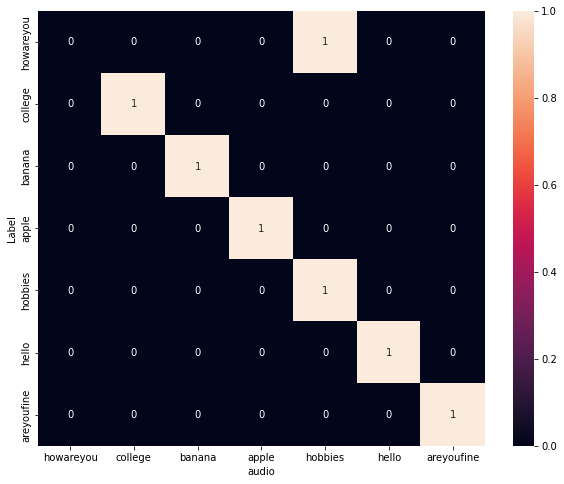

In [121]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=words,
            yticklabels=words,
            annot=True, fmt='g')
plt.xlabel('audio')
plt.ylabel('Label')
plt.show()